# Convex unmixer

Notebook that uses a network representation of sample localities to unmix sedimentary geochemical data. 

In [1]:
import os
import sys
print(sys.version)
print(os.getcwd())

import cvxpy as cp
import geochem_inverse_optimize as gio
import matplotlib.pyplot as plt

3.10.4 (main, Mar 31 2022, 08:41:55) [GCC 7.5.0]
/home/rick/projects/contributing/faster-unmixer


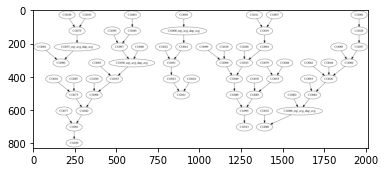

Compiling and solving problem...
                                     CVXPY                                     
                                     v1.2.1                                    
(CVXPY) Jun 16 05:44:29 PM: Your problem has 3276 variables, 0 constraints, and 0 parameters.
(CVXPY) Jun 16 05:44:30 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jun 16 05:44:30 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jun 16 05:44:30 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jun 16 05:44:31 PM: Compiling problem (target solver=SCS).
(CVXPY) Jun 16 05:44:31 PM: Reduction chain: Dcp2Cone -> CvxAt

/home/rick/miniconda3/envs/faster-unmixer/lib/python3.10/site-packages/cvxpy/problems/problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
(CVXPY) Jun 16 05:45:09 PM: Problem status: optimal_inaccurate
(CVXPY) Jun 16 05:45:09 PM: Optimal value: 1.393e+03
(CVXPY) Jun 16 05:45:09 PM: Compilation took 2.343e+01 seconds
(CVXPY) Jun 16 05:45:09 PM: Solver (including time spent in interface) took 1.440e+01 seconds
   sample_name  Li_obs     Li_pred  Be_obs    Be_pred   Na_obs     Na_pred  \
0        CG090    35.9   93.036101   1.824   1.824001  12610.0  498.311950   
1        CG039    20.2   83.923234   2.533   3.337711  12535.0  502.512250   
2        CG021    38.1   95.880252   2.564   2.564004  13851.0  500.932103   
3        CG013    23.4   68.678285   1.978   1.978003  18507.0  500.644799   
4        CG088    24.2   89.337243   3.922   4.038970  19162.0  501.246038   
..         ...     

In [2]:
sample_network, sample_adjacency = gio.get_sample_graphs("data/")

gio.plot_network(sample_network)

obs_data, element_list = gio.get_sample_data("data/geochem_no_dupes.dat")

primary_terms = gio.get_primary_terms(sample_network=sample_network, obs_data=obs_data, element_list=element_list)

regularizer_terms = gio.get_regularizer_terms(sample_network=sample_network, adjacency_graph=sample_adjacency)

if not regularizer_terms:
    print("WARNING: No regularizer terms found!")

# Build the objective and constraints
regularizer_strength = 1e-3
objective = cp.norm(cp.vstack(primary_terms))
if regularizer_terms:
  objective += regularizer_strength * cp.norm(cp.vstack(regularizer_terms))
constraints = []

# Create and solve the problem
print("Compiling and solving problem...")
problem = cp.Problem(cp.Minimize(objective), constraints)
# Solvers that can handle this problem type include:
# ECOS, SCS
# See: https://www.cvxpy.org/tutorial/advanced/index.html#choosing-a-solver
objective_value = problem.solve(solver=cp.SCS, verbose=True, max_iters=10000)

soldf = gio.get_solution_dataframe(sample_network=sample_network, obs_data=obs_data)

In [4]:
soldf

,sample_name,Li_obs,Li_pred,Be_obs,Be_pred,Na_obs,Na_pred,Mg_obs,Mg_pred,Al_obs,...,W_obs,W_pred,Tl_obs,Tl_pred,Pb_obs,Pb_pred,Th_obs,Th_pred,U_obs,U_pred
0,CG090,35.9,93.036101,1.824,1.824001,12610.0,498.311950,12137.0,498.250597,66239.0,...,0.742,0.742000,0.532,0.532000,22.034,74.896956,8.65,13.789011,2.090,2.090002
1,CG039,20.2,83.923234,2.533,3.337711,12535.0,502.512250,7068.0,489.448308,60476.0,...,0.986,1.459208,0.892,0.892000,27.410,91.766591,12.41,57.998030,4.097,5.476559
2,CG021,38.1,95.880252,2.564,2.564004,13851.0,500.932103,14289.0,500.983389,74752.0,...,1.858,1.858001,0.622,0.622000,188.368,112.465500,12.94,42.158738,6.204,6.161368
3,CG013,23.4,68.678285,1.978,1.978003,18507.0,500.644799,10268.0,497.868761,71512.0,...,0.473,0.672792,0.422,0.422000,31.866,90.212803,7.35,12.402413,3.100,3.217999
4,CG088,24.2,89.337243,3.922,4.038970,19162.0,501.246038,8466.0,496.984302,62926.0,...,3.296,4.069512,1.015,1.015000,38.507,105.236876,34.71,95.005918,10.048,36.410400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,CG057,32.3,103.130231,5.575,5.570470,18190.0,529.994965,11316.0,528.728101,67847.0,...,1.568,1.567998,1.001,1.001001,34.062,106.187538,19.95,80.580500,16.847,40.172932
59,CG025,40.0,92.530000,6.399,6.399967,20383.0,517.558028,4917.0,515.029859,72974.0,...,2.533,2.533002,1.397,1.397001,40.986,95.698800,23.24,56.692603,9.761,18.855539
60,CG045,14.0,36.662340,2.475,2.475004,21532.0,527.653986,6271.0,523.147277,69617.0,...,0.417,0.417000,0.525,0.525000,29.443,87.094813,11.16,13.563280,3.494,3.494003
61,CG061,44.3,75.879200,15.656,15.554136,24013.0,501.838155,1127.0,486.677006,67151.0,...,3.276,3.276007,2.117,2.117002,64.880,97.240663,38.43,62.097796,67.659,55.517627
